# Python Companion to *Visualizing Data by William S. Cleveland* with plotnine and pandas
## Chapter 2 - Univariate Data - Sections 2.1 to 2.5
#### Dataset: NY Choral Society Singer Heights

#### Contents

+ Setup, Data Preparation
+ Introduction
+ 2.1 Quantile Plots
+ 2.2 Q-Q Plots
+ 2.3 Box Plots
+ 2.4 Normal Q-Q Plots
+ 2.5 Fits and Residuals

---

# Setup, Data Preparation

### Imports

In [1]:
# Setup function to print major versions - similar to movingpandas
!which python

/home/david/mambaforge/envs/cleveland/bin/python


In [2]:
import os
import math
from pathlib import Path

import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import plotnine
from plotnine import *
# import matplotlib.pyplot as plt
import rpy2
from scipy.stats import norm, probplot

### Defaults

In [3]:
# plotnine.themes.theme_set(theme_bw())
plotnine.options.current_theme=theme_bw()
plotnine.options.figure_size=(4, 4)
pd.set_option('display.max_columns', 100)

### Data Directory

In [4]:
%load_ext dotenv
%dotenv
PROJECT_DIR=Path(os.environ.get('PROJECT_DIR'))
DATA_DIR = PROJECT_DIR / 'book' / 'data'
DATA_DIR_STR = str(DATA_DIR)
DATA_DIR

PosixPath('/media/david/T7/code/cleveland-visualizing-data/book/data')

## Get the Data from the R `lattice` package

+ [The Data and Story Library - singers_by_parts](https://dasl.datadescription.com/datafile/singers-by-parts/)

In [5]:
%load_ext rpy2.ipython

by .GlobalEnv when processing object ‘.pbd_env’


In [6]:
%%R -i DATA_DIR_STR
library(lattice)
data <- singer
filepath <- paste0(DATA_DIR_STR, "/" , "singers.csv")

write.csv(singer, filepath, row.names=FALSE)

## Load the Data and setup datatypes

In [7]:
df_orig = pd.read_csv(DATA_DIR / "singers.csv")
df_orig = df_orig.rename(columns={"voice.part": "voice_part"})
pitch_order = ['Bass 2', 'Bass 1', 'Tenor 2', 'Tenor 1', 'Alto 2', 'Alto 1', 'Soprano 2', 'Soprano 1']
cat_type=CategoricalDtype(categories=pitch_order, ordered=True)
df_orig['voice_part'] = df_orig['voice_part'].astype(cat_type)
# df_orig['all_data'] = 'all'
# df_orig['all_data'] = df_orig['all_data'].astype('category')
df_orig.head()

,height,voice_part
0,64,Soprano 1
1,62,Soprano 1
2,66,Soprano 1
3,65,Soprano 1
4,60,Soprano 1


## Profile the Data

In [8]:
df_orig.isna().sum()

height        0
voice_part    0
dtype: int64

In [9]:
profile = df_orig.groupby(by='voice_part').describe()
profile = profile.sort_values(by=[('height', 'mean')], ascending=[False])
profile

height                                                     
            count       mean       std   min    25%   50%    75%   max
voice_part                                                            
Bass 2       26.0  71.384615  2.728764  66.0  70.00  72.0  74.00  75.0
Bass 1       39.0  70.717949  2.361408  66.0  69.00  71.0  72.00  75.0
Tenor 2      21.0  69.904762  2.071346  66.0  69.00  69.0  71.00  76.0
Tenor 1      21.0  68.904762  3.330237  64.0  66.00  68.0  71.00  76.0
Alto 2       27.0  66.037037  2.344904  63.0  64.00  66.0  67.00  70.0
Alto 1       35.0  64.885714  2.794653  60.0  63.00  65.0  66.50  72.0
Soprano 1    36.0  64.250000  1.872737  60.0  62.75  65.0  65.00  68.0
Soprano 2    30.0  63.966667  2.525502  60.0  62.00  64.0  65.75  70.0

In [10]:
df_orig.head()

,height,voice_part
0,64,Soprano 1
1,62,Soprano 1
2,66,Soprano 1
3,65,Soprano 1
4,60,Soprano 1


---

# Introduction
About the data:
+ [ singer: Heights of New York Choral Society singers In lattice](https://rdrr.io/rforge/lattice/man/singer.html)
+ Heights of singers in the New York Choral Society.
+ Lower left plot shows Bass 2 - the lowest pitch. Pitch increases left to right, bottom to top to Soprano 1 - the highest pitch.
+ This is univariate data split into groups by a categorical variable - `voice part`.
+ The relationship between voice part/pitch and height is not obvious from figure 1.2
+ The bottom 4 panels are all men, and the top 4 panels are all women.
+ The heights are rounded to the nearest inch.

## Analysis Question
Do heights tend to decrease as the pitch interval increases?

---

# Section 1.1 Tools and Data Types

## 1.1 - Fig 1.2 Multi-Category Histograms

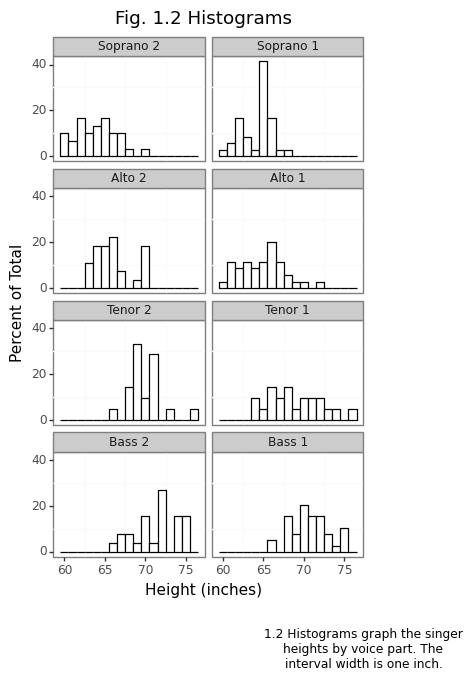

In [11]:
binwidth=1
p = (ggplot(df_orig, aes(x='height', y=after_stat('density*100'), group='voice_part')) +
     geom_histogram(binwidth=1, fill='white', color='black') +     
     facet_wrap(facets='voice_part', nrow=4, ncol=2, as_table=False) +
     scale_y_continuous(breaks=np.linspace(0, 40, 3)) +
     # theme_bw() +
     theme(figure_size=(4,6.5), plot_caption=element_text(hjust=0.5), panel_grid_major=element_blank()) +
     xlab("Height (inches)") +
     ylab("Percent of Total") +
     labs(title="Fig. 1.2 Histograms",
          caption="1.2 Histograms graph the singer\nheights by voice part. The\ninterval width is one inch.")
    )
p.draw();

---

# Section 2.1 Quantile Plots

## 2.1 - Fig 2.1 Multi-Category Quantile Plot

### Data Preparation

In [12]:
def quantiles(df_orig, cat_col, var_col, q_method='inverted_cdf'):
    
    cat_dfs = []
    for cat, cat_df in df_orig.groupby(by=cat_col):
        cat_df = cat_df.sort_values(by=var_col)
        i = np.arange(0, len(cat_df), 1) + 1
        cat_df['f-value'] = (i - 0.5) / len(cat_df)
        cat_df[var_col] = np.quantile(cat_df[var_col], cat_df['f-value'].values, method=q_method)
        cat_dfs.append(cat_df)
    f_df = pd.concat(cat_dfs, axis=0).sort_values(by=[cat_col, var_col]).reset_index(drop=True)

    return f_df

In [13]:
df8 = df_orig.copy()
qq_norms = quantiles(df8, 'voice_part', 'height')
qq_norms.head()

,height,voice_part,f-value
0,66,Bass 2,0.019231
1,67,Bass 2,0.057692
2,67,Bass 2,0.096154
3,68,Bass 2,0.134615
4,68,Bass 2,0.173077


### Plot

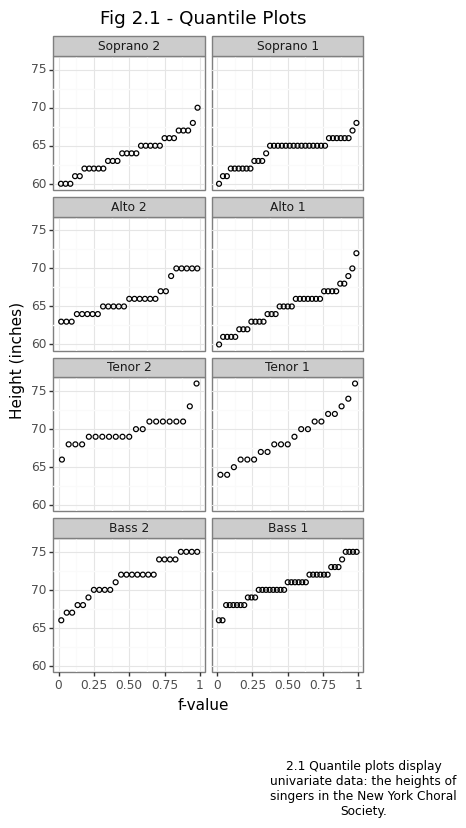

In [14]:
p = (ggplot(qq_norms, aes(x="f-value", y="height")) +
     geom_point(fill='none') +
     # geom_line(alpha=0.5) + 
     facet_wrap(facets='voice_part', nrow=4, ncol=2, as_table=False) +
     # theme_bw() +
     theme(figure_size=(4,8), plot_caption=element_text(hjust=0.5)) +
     xlab("f-value") +
     ylab("Height (inches)") +
     labs(title="Fig 2.1 - Quantile Plots",
          caption='2.1 Quantile plots display\nunivariate data: the heights of\nsingers in the New York Choral\nSociety.'))
p.draw()

## 2.1 - Fig 2.2 Quantile Plot

### Data Preparation

In [15]:
df3 = df_orig.copy()
tenor1 = df3[df3['voice_part']=='Tenor 1']
tenor1q = quantiles(tenor1, 'voice_part', 'height')
tenor1q.head()

,height,voice_part,f-value
0,64,Tenor 1,0.023810
1,64,Tenor 1,0.071429
2,65,Tenor 1,0.119048
3,66,Tenor 1,0.166667
4,66,Tenor 1,0.214286


### Plot

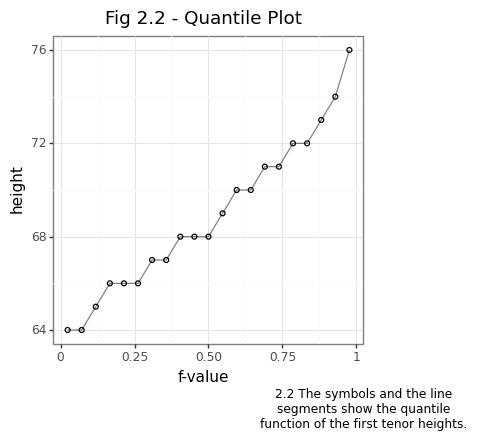

In [16]:
p = (ggplot(tenor1q, aes(x="f-value", y="height")) +
     geom_point(fill='none') +
     geom_line(alpha=0.5) + 
     # facet_wrap(facets='voice_part', nrow=4, ncol=2, as_table=False) +
     theme_bw() +
     # theme(figure_size=(4,4)) +
     theme(figure_size=(4,4), plot_caption=element_text(hjust=0.5)) +
     labs(title="Fig 2.2 - Quantile Plot",
          caption='2.2 The symbols and the line\nsegments show the quantile\nfunction of the first tenor heights.'))
p.draw()

---

# Section 2.2 Q-Q Plots

## 2.2 - Fig 2.3 Q-Q Plot

### Data Preparation

In [17]:
def qq_quantiles(df, cat_col, var_col, cols):
    x = df[df[cat_col]==cols[0]][var_col].rename(cols[0] + ' ' + var_col)
    y = df[df[cat_col]==cols[1]][var_col].rename(cols[1] + ' ' + var_col)
    # deal with same length arrays
    if len(x)==len(y):
        min_len_arr = x
        max_len_arr = y
    else: # deal with different length arrays
        min_len_arr = [x, y][np.argmin([len(x), len(y)])]
        max_len_arr = [x, y][np.argmax([len(x), len(y)])]
    x_name = min_len_arr.name
    y_name = max_len_arr.name
    min_len = len(min_len_arr)
    
    min_len_arr = np.sort(min_len_arr)
    i = np.arange(0, min_len, 1) + 1
    f_i = (i - 0.5) / min_len
    
    max_len_arr_q = np.quantile(max_len_arr, f_i, method='linear')

    return pd.DataFrame({x_name: min_len_arr, y_name: max_len_arr_q})

In [18]:
df4 = df_orig.copy()
qq = qq_quantiles(df4, 'voice_part', 'height', ['Tenor 1', 'Bass 2'])
qq.head()

,Tenor 1 height,Bass 2 height
0,64,66.595238
1,64,67.000000
2,65,67.976190
3,66,68.166667
4,66,69.357143


### Plot

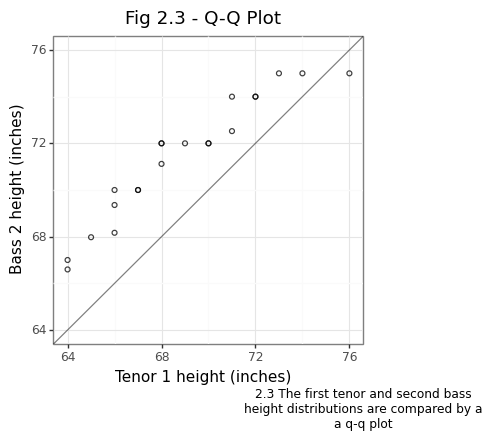

In [19]:
p = (ggplot(qq, aes(x='Tenor 1 height', y='Bass 2 height')) +
     geom_point(fill='none', alpha=0.75) +
     geom_abline(intercept=0, slope=1, alpha=0.5) +
     coord_cartesian(xlim=(qq.min().min(), qq.max().max()), ylim=(qq.min().min(), qq.max().max())) +  
     xlab("Tenor 1 height (inches)") +
     ylab("Bass 2 height (inches)") +
     labs(title="Fig 2.3 - Q-Q Plot",
         caption="2.3 The first tenor and second bass\nheight distributions are compared by a\na q-q plot") +
     theme_bw() +
     theme(figure_size=(4,4), plot_caption=element_text(hjust=0.5)))

p.draw()

## 2.2 - Fig 2.4 Tukey Mean-Difference Plot

### Data Preparation

In [20]:
def mean_diffs(qq):
    qq['mean'] = qq.mean(axis=1)
    qq['diff'] = qq.apply(lambda x: x[1] - x[0], axis=1)
    return qq

In [21]:
df5 = df_orig.copy()
qq = qq_quantiles(df5, 'voice_part', 'height', ['Tenor 1', 'Bass 2'])
md = mean_diffs(qq)

md.head()

,Tenor 1 height,Bass 2 height,mean,diff
0,64,66.595238,65.297619,2.595238
1,64,67.000000,65.500000,3.000000
2,65,67.976190,66.488095,2.976190
3,66,68.166667,67.083333,2.166667
4,66,69.357143,67.678571,3.357143


### Plot

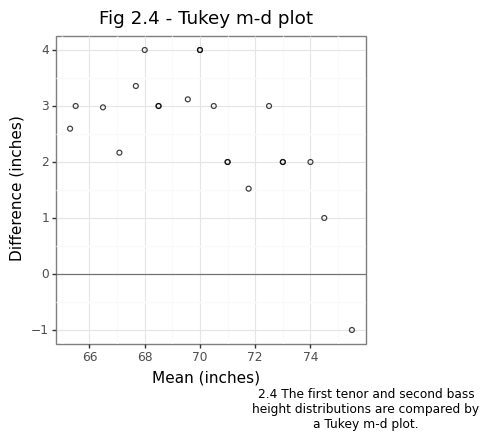

In [22]:
p = (ggplot(md, aes(x='mean', y='diff')) +
     geom_point(fill='none', alpha=0.75) +
     geom_abline(intercept=0, slope=0, alpha=0.5) +
     # geom_abline(intercept=md['diff'].mean(), slope=0, alpha=0.3, color='red') +
     scale_x_continuous(breaks=np.arange(math.floor(md['mean'].min()-1), math.ceil(md['mean'].max()), 2)) +
     xlab("Mean (inches)") +
     ylab("Difference (inches)") +
     labs(title="Fig 2.4 - Tukey m-d plot",
          caption='2.4 The first tenor and second bass\nheight distributions are compared by\na Tukey m-d plot.') +
     theme_bw() +
     theme(figure_size=(4,4), plot_caption=element_text(hjust=0.5)))
p.draw()

## 2.2 - Fig. 2.5 Pairwise Q-Q Plots

### Data Preparation

In [23]:
from itertools import combinations

def pairwise_qq(df, cat_col, var_col):
    
    cat_type=CategoricalDtype(categories=df[cat_col].cat.categories, ordered=True)
    # Use unique to get actual categories in the df data, in case some are absent in the df
    pairs = combinations(df[cat_col].unique(), 2)
    
    dfs = []
    for pair in pairs:
        qq = qq_quantiles(df, cat_col, var_col, pair)
        qq['row'] = pair[0]
        qq['col'] = pair[1]
        # Deal with the way that qq_quantiles function names the columns
        qq = qq.rename(columns={col: col.replace(" " + var_col, "") for col in qq.columns})
        # Make a dictionary - use it for col renaming
        lookup_d = {qq['row'].unique()[0]: 'row', qq['col'].unique()[0]: 'col'}
        qq = qq.rename(columns={col: lookup_d[col] + '_vals' for col in qq.columns if col not in ['row', 'col']})
        dfs.append(qq)
        
    df = pd.concat(dfs, axis=0).reset_index(drop=True)
    df['col'] = df['col'].astype(cat_type)
    df['row'] = df['row'].astype(cat_type)
    return df   

In [24]:
df6 = df_orig.copy()
qq_pairs = pairwise_qq(df6, 'voice_part', 'height')
qq_pairs.head()

,col_vals,row_vals,row,col
0,60.0,60.583333,Soprano 1,Soprano 2
1,60.0,61.000000,Soprano 1,Soprano 2
2,60.0,61.916667,Soprano 1,Soprano 2
3,61.0,62.000000,Soprano 1,Soprano 2
4,61.0,62.000000,Soprano 1,Soprano 2


In [25]:
qq_pairs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707 entries, 0 to 706
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   col_vals  707 non-null    float64 
 1   row_vals  707 non-null    float64 
 2   row       707 non-null    category
 3   col       707 non-null    category
dtypes: category(2), float64(2)
memory usage: 13.3 KB


### Plot

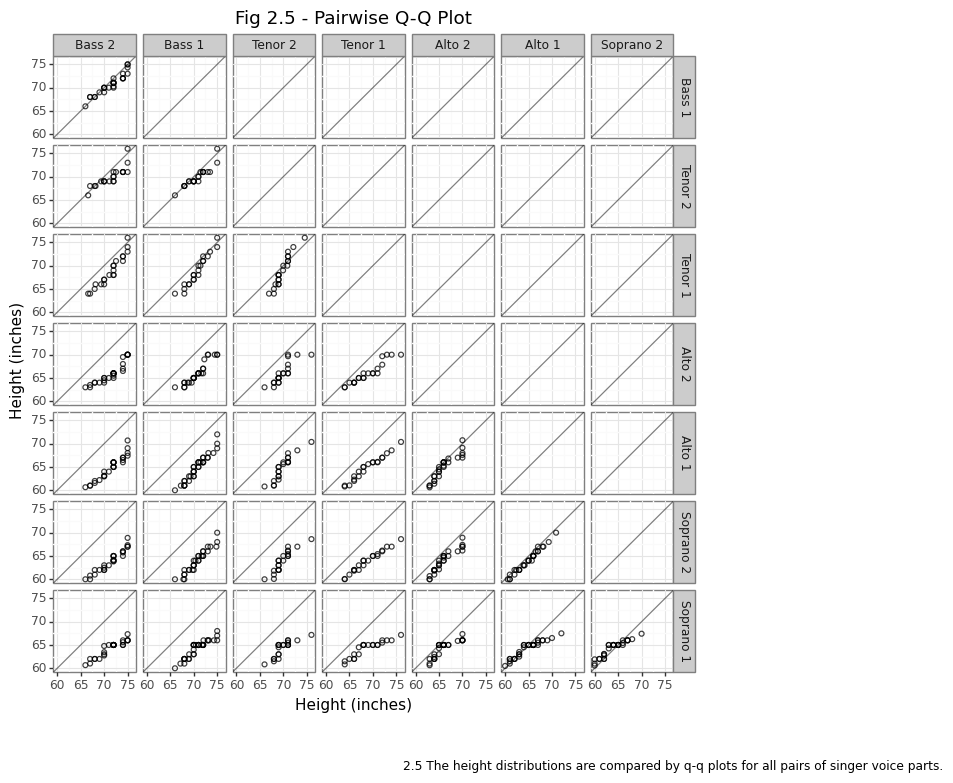

In [26]:
p = (ggplot(qq_pairs, aes(x='col_vals', y='row_vals')) +
     geom_point(fill='none', alpha=0.75) +
     geom_abline(intercept=0, slope=1, alpha=0.5) +
     # coord_cartesian(xlim=(qq.min().min(), qq.max().max()), ylim=(qq.min().min(), qq.max().max())) +  
     # xlab("none") +
     # ylab("Bass 2 height (inches)") +
     labs(title="Fig 2.5 - Pairwise Q-Q Plot",
           caption='2.5 The height distributions are compared by q-q plots for all pairs of singer voice parts.') +
     theme_bw() +
     # theme(axis.title.x=element_blank()) +
     labs(x="Height (inches)") + 
     labs(y="Height (inches)") +
     facet_grid('row ~ col', as_table=True) +
     theme(figure_size=(8,8), plot_caption=element_text(hjust=0.5)))

p.draw()

---

# Section 2.3 Box Plots

## 2.3 - Fig. 2.8 Box Plots

### Plot

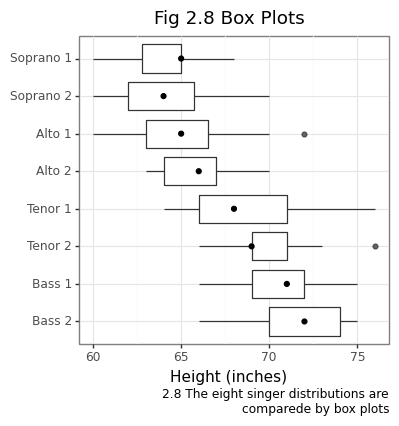

In [27]:
# df7 = df_orig.copy()
mean_heights = df_orig.groupby(by=['voice_part'])['height'].mean()
p = (ggplot(df_orig, aes(y='height', x='voice_part')) +
     geom_boxplot(fatten=0, outlier_shape='o', outlier_alpha=0.75) +
     stat_summary(aes(y='height', group='voice_part'), fun_y=np.median, geom="point") +
     coord_flip() +
     ylab("Height (inches)") +
     xlab("") +
     labs(title="Fig 2.8 Box Plots",
          caption="2.8 The eight singer distributions are\ncomparede by box plots") +
     theme_bw()
    )
p.draw()

---

# Section 2.4 Normal Q-Q Plots

## 2.4 - Fig. 2.9 Quantile Plot

### Data Preparation

In [28]:
df = df_orig.copy()
alto_1df = df[df['voice_part']=='Alto 1']
alto_1q = quantiles(alto_1df, 'voice_part', 'height', q_method='inverted_cdf')
alto_1q.head()

,height,voice_part,f-value
0,60,Alto 1,0.014286
1,61,Alto 1,0.042857
2,61,Alto 1,0.071429
3,61,Alto 1,0.100000
4,61,Alto 1,0.128571


### Plot

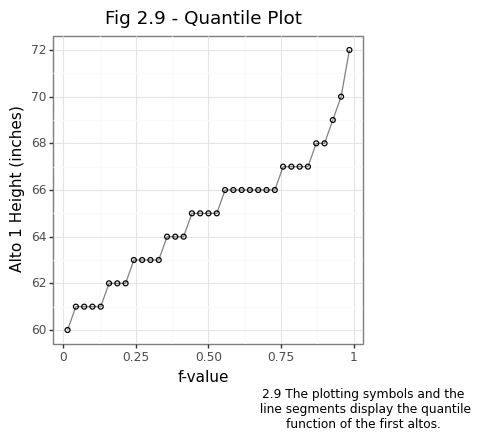

In [29]:
p = (ggplot(alto_1q, aes(x="f-value", y="height")) +
     geom_point(fill='none') +
     geom_line(alpha=0.5) + 
     theme_bw() +
     scale_y_continuous(breaks=np.arange(math.floor(alto_1q['height'].min()-2), math.ceil(alto_1q['height'].max()+2), 2)) +
     theme(figure_size=(4,4), plot_caption=element_text(hjust=0.5)) +
     ylab("Alto 1 Height (inches)") +
     labs(title="Fig 2.9 - Quantile Plot",
          caption='2.9 The plotting symbols and the\n line segments display the quantile\nfunction of the first altos.'))
p.draw()

## 2.4 - Fig. 2.10 Normal Quantile Plot

### Data Preparation

In [30]:
na1df = df[df['voice_part']=='Alto 1']
na1df = quantiles(na1df, 'voice_part', 'height', q_method='inverted_cdf')
na1df['norm_height'] = norm.ppf(na1df['f-value'].values, na1df['height'].mean(), na1df['height'].std()) 
na1df.head()

,height,voice_part,f-value,norm_height
0,60,Alto 1,0.014286,58.767242
1,61,Alto 1,0.042857,60.083239
2,61,Alto 1,0.071429,60.790895
3,61,Alto 1,0.100000,61.304223
4,61,Alto 1,0.128571,61.718898


### Plot

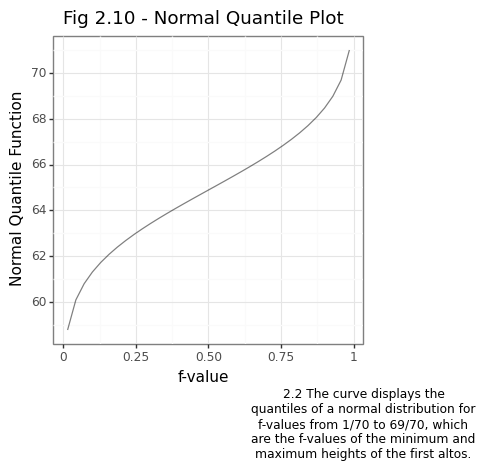

In [31]:
p = (ggplot(na1df, aes(x="f-value", y="norm_height")) +
     geom_line(alpha=0.5) + 
     theme_bw() +
     scale_y_continuous(breaks=np.arange(math.floor(na1df['height'].min())-2, math.ceil(na1df['height'].max()), 2)) +
     theme(figure_size=(4,4), plot_caption=element_text(hjust=0.5)) +
     ylab("Normal Quantile Function") +
     labs(title="Fig 2.10 - Normal Quantile Plot",
          caption='2.2 The curve displays the\nquantiles of a normal distribution for\nf-values from 1/70 to 69/70, which\nare the f-values of the minimum and\nmaximum heights of the first altos.'))
p.draw()

## 2.4 - Fig. 2.11 Multi Category Normal q-q Plots

### Data Preparation

In [32]:
def theoretical_qq(df, cat_col, var_col, dist='norm'):
    cat_type=CategoricalDtype(categories=df[cat_col].cat.categories, ordered=True)
    
    qdfs = []
    for cat, cat_df in df.groupby(by=cat_col):
        xys, line_def = probplot(cat_df[var_col].values, dist=dist)
        qdf = pd.DataFrame({cat_col: cat, 'theory_quantiles': xys[0], var_col: xys[1],
                            'slope': line_def[0], 'intercept': line_def[1]})
        qdfs.append(qdf)
        
    df = pd.concat(qdfs, axis=0).reset_index(drop=True)
    df[cat_col] = df[cat_col].astype(cat_type)
    return df 

In [33]:
df8 = df_orig.copy()
qq_norms = theoretical_qq(df8, 'voice_part', 'height', dist='norm')
qq_norms.head()

,voice_part,theory_quantiles,height,slope,intercept
0,Bass 2,-1.938071,66,2.768226,71.384615
1,Bass 2,-1.523509,67,2.768226,71.384615
2,Bass 2,-1.271673,67,2.768226,71.384615
3,Bass 2,-1.081786,68,2.768226,71.384615
4,Bass 2,-0.924539,68,2.768226,71.384615


### Plot

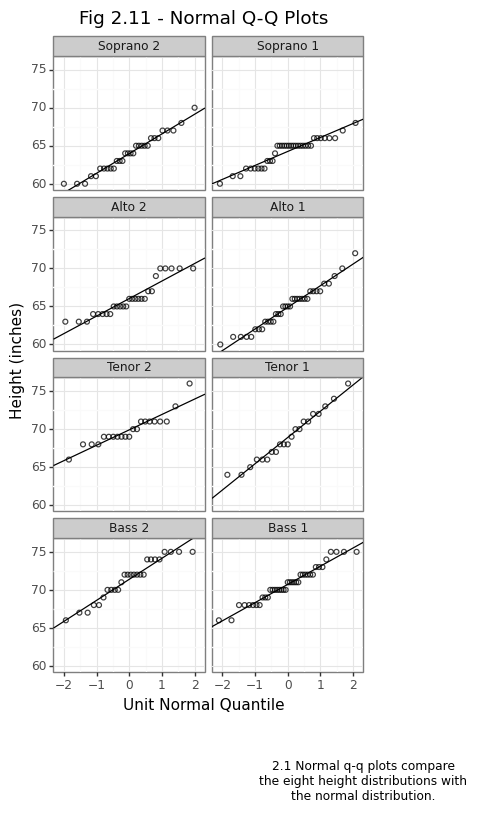

In [34]:
p = (ggplot(qq_norms, aes(x='theory_quantiles', y='height')) +
     geom_point(fill='none', alpha=0.75) +
     geom_abline(aes(intercept='intercept', slope='slope', alpha=0.5)) +
     labs(title="Fig 2.11 - Normal Q-Q Plots",
          caption='2.1 Normal q-q plots compare\nthe eight height distributions with\nthe normal distribution.') +
     theme_bw() + 
     xlab("Unit Normal Quantile") + 
     ylab("Height (inches)") +
     facet_wrap('~voice_part', ncol=2, as_table=False) +
     theme(legend_position='none') +
     theme(figure_size=(4, 8), plot_caption=element_text(hjust=0.5))
    )
p.draw()

---

# 2.5 Fits and Residuals

## 2.5 - Fig. 2.12 Dot Plot of Sample Means

### Plot

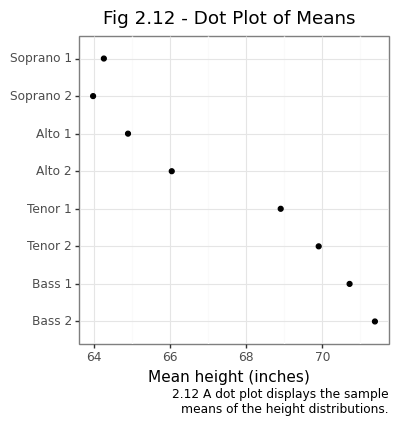

In [35]:
# Remove vertical lines
p = (ggplot(df_orig, aes(x='voice_part', y='height')) +
     geom_point(stat="summary", fun_y=np.mean) +
     labs(title="Fig 2.12 - Dot Plot of Means",
          caption='2.12 A dot plot displays the sample\nmeans of the height distributions.') +
     theme_bw() +
     ylab("Mean height (inches)") +
     xlab("") +
     coord_flip()
    )
p.draw()

## 2.5 - Fig. 2.13 Box Plot of Residual Distributions

### Data Preparation

In [36]:
def qq_resids(qq_df, cat_col, var_col):
    cat_dfs = []
    for cat, cat_df in qq_df.groupby(by=cat_col):
        cat_df['resid'] = cat_df[var_col] - cat_df[var_col].mean()
        cat_dfs.append(cat_df)
    df = pd.concat(cat_dfs, axis=0)
    return df

In [37]:
qq_norms = theoretical_qq(df, 'voice_part', 'height', dist='norm')
qq_res = qq_resids(qq_norms, 'voice_part', 'height')
qq_res.head()

,voice_part,theory_quantiles,height,slope,intercept,resid
0,Bass 2,-1.938071,66,2.768226,71.384615,-5.384615
1,Bass 2,-1.523509,67,2.768226,71.384615,-4.384615
2,Bass 2,-1.271673,67,2.768226,71.384615,-4.384615
3,Bass 2,-1.081786,68,2.768226,71.384615,-3.384615
4,Bass 2,-0.924539,68,2.768226,71.384615,-3.384615


### Plot

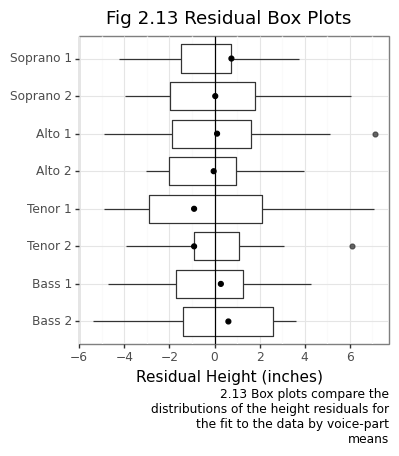

In [38]:
mean_heights = qq_res.groupby(by=['voice_part'])['height'].mean()
p = (ggplot(qq_res, aes(y='resid', x='voice_part')) +
     geom_boxplot(fatten=0, outlier_shape='o', outlier_alpha=0.75) +
     stat_summary(aes(y='resid', group='voice_part'), fun_y=np.median, geom="point") +
     geom_hline(yintercept=0) +
     scale_y_continuous(breaks=range(-8, 8, 2)) +
     coord_flip() +
     ylab("Residual Height (inches)") +
     xlab("") +
     labs(title="Fig 2.13 Residual Box Plots",
          caption="2.13 Box plots compare the\ndistributions of the height residuals for\nthe fit to the data by voice-part\nmeans") +
     theme_bw()
    )
p.draw()

## 2.5 - Fig. 2.14 Multi Category q-q Plot of Category Residuals versus Pooled Residuals

### Data Preparation

In [39]:
qq_res1 = qq_res.copy()
qq_res1['all'] = 'all'
qq_res1['all'] = qq_res1['all'].astype('category')
qq_res1 = quantiles(qq_res1, 'all', 'resid', q_method='inverted_cdf').sort_index()
qq_res1.head()

,voice_part,theory_quantiles,height,slope,intercept,resid,all,f-value
0,Bass 2,-1.938071,66,2.768226,71.384615,-5.384615,all,0.002128
1,Tenor 1,-1.413528,64,3.457361,68.904762,-4.904762,all,0.006383
2,Tenor 1,-1.845695,64,3.457361,68.904762,-4.904762,all,0.010638
3,Alto 1,-2.061884,60,2.848351,64.885714,-4.885714,all,0.014894
4,Bass 1,-1.719727,66,2.396453,70.717949,-4.717949,all,0.019149


In [40]:
def residuals_qq(df, cat_col, var_col):
    
    cat_type=CategoricalDtype(categories=df[cat_col].cat.categories, ordered=True)
    # Calculate the residuals associated with each category
    qq_norms = theoretical_qq(df, 'voice_part', 'height', dist='norm')
    qq_res = qq_resids(qq_norms, 'voice_part', 'height')
    pooled_resids = qq_res.copy()
    pooled_resids[cat_col] = 'resid'
    
    qq_dfs = []
    for cat, cat_df in qq_res.groupby(by=cat_col):
        pair = [cat, 'resid']
        pair_df = pd.concat([cat_df, pooled_resids], axis=0)
        qq_df = qq_quantiles(pair_df, cat_col, 'resid', pair)
        qq_df[cat_col]=cat
        qq_df = qq_df.rename(columns={'resid resid': 'pooled_resid', cat + ' resid': 'resid'})
        qq_dfs.append(qq_df)
    result_df = pd.concat(qq_dfs, axis=0).reset_index(drop=True)
    result_df[cat_col] = result_df[cat_col].astype(cat_type)

    return result_df
    
    

In [41]:
df10 = df_orig.copy()
dfqr = residuals_qq(df10, 'voice_part', 'height') 
dfqr.head()

,resid,pooled_resid,voice_part
0,-5.384615,-4.717949,Bass 2
1,-4.384615,-3.895238,Bass 2
2,-4.384615,-3.037037,Bass 2
3,-3.384615,-2.885714,Bass 2
4,-3.384615,-2.250000,Bass 2


### Plot

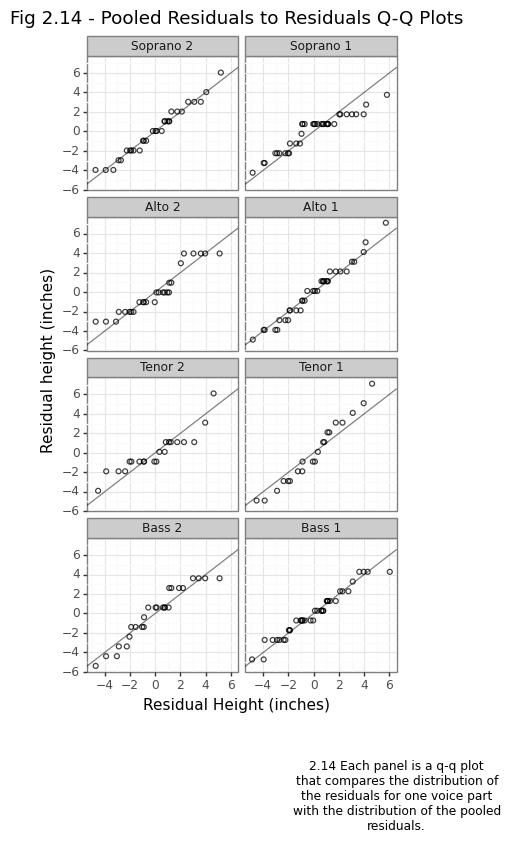

In [42]:
p = (ggplot(dfqr, aes(x='pooled_resid', y='resid', group='voice_part')) +
     geom_point(fill='none', alpha=0.75) +
     geom_abline(aes(intercept=0.0, slope=1.0), alpha=0.5) +
     labs(title="Fig 2.14 - Pooled Residuals to Residuals Q-Q Plots",
          caption='2.14 Each panel is a q-q plot\nthat compares the distribution of\nthe residuals for one voice part\nwith the distribution of the pooled\nresiduals.') +
     theme_bw() + 
     xlab("Residual Height (inches)") + 
     ylab("Residual height (inches)") +
     facet_wrap('~voice_part', ncol=2, as_table=False) +
     scale_x_continuous(breaks=np.linspace(-8, 8, 9)) +
     scale_y_continuous(breaks=np.linspace(-8, 8, 9)) +
     # geom_abline(aes(intercept='intercept', slope='slope')) +
     theme(legend_position='none') +
     theme(figure_size=(4, 8), plot_caption=element_text(hjust=0.5))
    )
p.draw()

## 2.5 - Fig. 2.15 Quantile Plot of Pooled Residuals

### Data Preparation

In [43]:
df12 = df_orig.copy()
qq_norms = theoretical_qq(df, 'voice_part', 'height', dist='norm')
qq_res = qq_resids(qq_norms, 'voice_part', 'height')
qq_res['all'] = 'all'
qqp_res = quantiles(qq_res, 'all', 'resid').sort_values(by=['voice_part', 'height']).reset_index(drop=True) 
qqp_res.head()

,voice_part,theory_quantiles,height,slope,intercept,resid,all,f-value
0,Bass 2,-1.938071,66,2.768226,71.384615,-5.384615,all,0.002128
1,Bass 2,-1.271673,67,2.768226,71.384615,-4.384615,all,0.027660
2,Bass 2,-1.523509,67,2.768226,71.384615,-4.384615,all,0.031915
3,Bass 2,-1.081786,68,2.768226,71.384615,-3.384615,all,0.078723
4,Bass 2,-0.924539,68,2.768226,71.384615,-3.384615,all,0.082979


### Plot

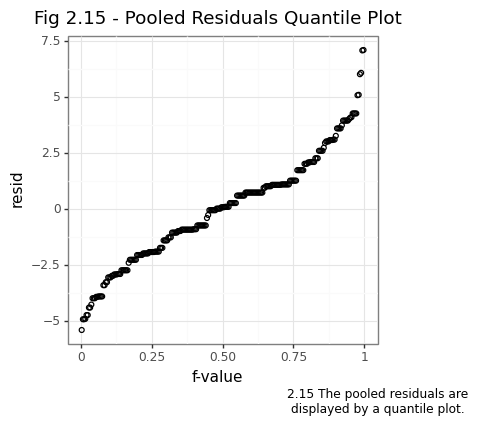

In [44]:
p = (ggplot(qqp_res, aes(x="f-value", y="resid")) +
     geom_point(fill='none') +
     theme_bw() +
     theme(figure_size=(4,4), plot_caption=element_text(hjust=0.5)) +
     labs(title="Fig 2.15 - Pooled Residuals Quantile Plot",
          caption='2.15 The pooled residuals are\ndisplayed by a quantile plot.'))
p.draw()

## 2.5 - Fig. 2.16 Normal q-q Plot of Pooled Residuals

### Data Preparation

In [45]:
df13 = df_orig.copy()
qq_norms = theoretical_qq(df, 'voice_part', 'height', dist='norm')
qq_res = qq_resids(qq_norms, 'voice_part', 'height')
qq_res['all'] = 'all'
qq_res['all'] = qq_res['all'].astype('category')
qq_norms = theoretical_qq(qq_res, 'all', 'resid', dist='norm')
qq_norms.head()

,all,theory_quantiles,resid,slope,intercept
0,all,-2.753819,-5.384615,2.47178,9.675476e-16
1,all,-2.449715,-4.904762,2.47178,9.675476e-16
2,all,-2.276863,-4.904762,2.47178,9.675476e-16
3,all,-2.153342,-4.885714,2.47178,9.675476e-16
4,all,-2.055930,-4.717949,2.47178,9.675476e-16


### Plot

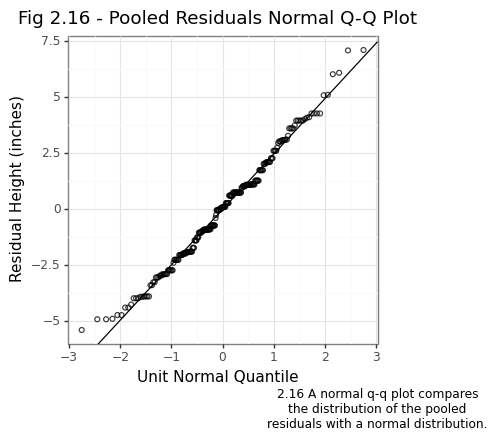

In [46]:
p = (ggplot(qq_norms, aes(x='theory_quantiles', y='resid')) +
     geom_point(fill='none', alpha=0.75) +
     geom_abline(aes(intercept='intercept', slope='slope', alpha=0.5)) +
     labs(title="Fig 2.16 - Pooled Residuals Normal Q-Q Plot",
          caption='2.16 A normal q-q plot compares\nthe distribution of the pooled\nresiduals with a normal distribution.') +
     theme_bw() + 
     xlab("Unit Normal Quantile") + 
     ylab("Residual Height (inches)") +
     theme(legend_position='none') +
     theme(figure_size=(4, 4), plot_caption=element_text(hjust=0.5))
    )
p.draw()

## 2.5 - Fig. 2.17 Residual-Fit (r-f) Spread Plot 

### Data Preparation

In [47]:
df12 = df_orig.copy()
qq_norms = theoretical_qq(df12, 'voice_part', 'height', dist='norm')
qq_res = qq_resids(qq_norms, 'voice_part', 'height')
qq_res['mean_height'] = qq_res.groupby(by=['voice_part'])['height'].transform('mean')
qq_res['diff'] = qq_res['height'] - qq_res['mean_height']
qq_res['all'] = 'all'
qq_res.head()

,voice_part,theory_quantiles,height,slope,intercept,resid,mean_height,diff,all
0,Bass 2,-1.938071,66,2.768226,71.384615,-5.384615,71.384615,-5.384615,all
1,Bass 2,-1.523509,67,2.768226,71.384615,-4.384615,71.384615,-4.384615,all
2,Bass 2,-1.271673,67,2.768226,71.384615,-4.384615,71.384615,-4.384615,all
3,Bass 2,-1.081786,68,2.768226,71.384615,-3.384615,71.384615,-3.384615,all
4,Bass 2,-0.924539,68,2.768226,71.384615,-3.384615,71.384615,-3.384615,all


In [48]:
qq_res2 = quantiles(qq_res, 'all', 'diff')
qq_res2['plot'] = 'Residuals'
qq_res2 = qq_res2
qq_res2 = qq_res2[['f-value', 'diff', 'plot']].sort_index().rename(columns={'diff': 'height'})
qq_res2.head()

,f-value,height,plot
0,0.002128,-5.384615,Residuals
1,0.006383,-4.904762,Residuals
2,0.010638,-4.904762,Residuals
3,0.014894,-4.885714,Residuals
4,0.019149,-4.717949,Residuals


In [49]:
qq_res1 = quantiles(qq_res, 'all', 'mean_height')
qq_res1 = qq_res1.sort_values(by='voice_part')
qq_res1['mean_height'] = qq_res1['mean_height'] - qq_res1['height'].mean()
qq_res1['plot'] = 'Fitted Values'
qq_res1 = qq_res1[['f-value', 'mean_height', 'plot']].sort_index().rename(columns={'mean_height': 'height'})
qq_res1.head()

,f-value,height,plot
0,0.002128,-3.331206,Fitted Values
1,0.006383,-3.331206,Fitted Values
2,0.010638,-3.331206,Fitted Values
3,0.014894,-3.331206,Fitted Values
4,0.019149,-3.331206,Fitted Values


In [50]:
rf_df = pd.concat([qq_res1, qq_res2], axis=0)
rf_df['plot'] = rf_df['plot'].astype(CategoricalDtype(['Fitted Values', 'Residuals'], ordered = True))
rf_df.head()

,f-value,height,plot
0,0.002128,-3.331206,Fitted Values
1,0.006383,-3.331206,Fitted Values
2,0.010638,-3.331206,Fitted Values
3,0.014894,-3.331206,Fitted Values
4,0.019149,-3.331206,Fitted Values


### Plot

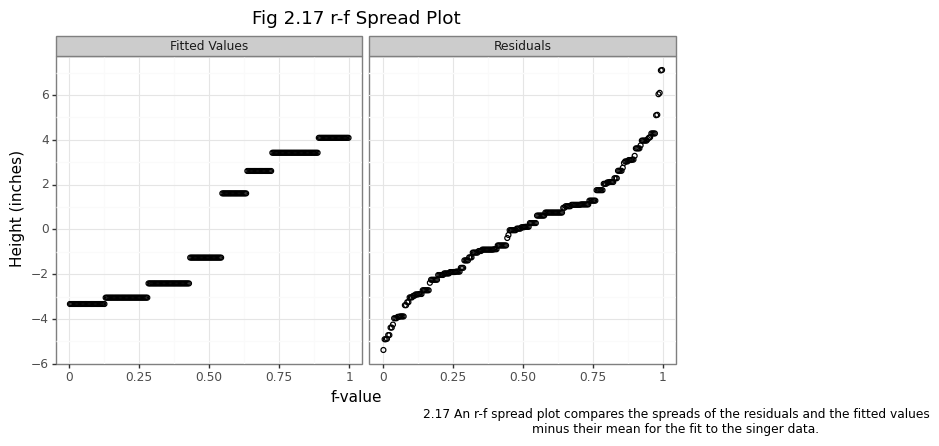

In [51]:
p = (ggplot(rf_df, aes(x="f-value", y="height")) +
     geom_point(fill='none') +
     facet_wrap(facets='plot', nrow=1, ncol=2, as_table=False) +
     scale_y_continuous(breaks=np.linspace(-6, 6, 7)) +
     theme_bw() +
     theme(figure_size=(8,4), plot_caption=element_text(hjust=0.5)) +
     ylab("Height (inches)") +
     labs(title="Fig 2.17 r-f Spread Plot",
          caption='2.17 An r-f spread plot compares the spreads of the residuals and the fitted values\nminus their mean for the fit to the singer data.'))
p.draw()